In [1]:
import os
import random
import pandas as pd
import matplotlib.image as mpimg


from os.path import join
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F

from sklearn import preprocessing
from torch import nn

from fastai.data.all import *
from fastai.vision.all import *

import warnings
warnings.filterwarnings("ignore")

# Task 

Predict 

- X4\ Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)

- X11\ Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)

- X18\ Plant height

- X26\ Seed dry mass

- X50\ Leaf nitrogen (N) content per leaf area

- X3112\ Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded)

From Images taken by cellphones and tabular data from 3 main cateogries which accompanies each image 

Tabluar data consists of :- 

-  WORLDCLIM_BIO[*] - These are ancillary climate variables that can be used to faciliate the trait prediction. The selection is based on Schiller et al. 2021.
-  SOIL_[*]- These are ancillary soil variables that can be used to faciliate the trait prediction.
-  MODIS_[*]/VOD_[*]- These are ancillary multitemporal satellite variables that can be used to faciliate the trait prediction (details see below).


In [2]:
class Config:
    sub = "/kaggle/input/planttraits2024/sample_submission.csv"
    trgts = "/kaggle/input/planttraits2024/target_name_meta.tsv"
    train_path = "/kaggle/input/planttraits2024/train.csv"
    test_path = "/kaggle/input/planttraits2024/test.csv"
    train_image_path = "/kaggle/input/planttraits2024/train_images/"
    test_image_path = "/kaggle/input/planttraits2024/test_images/"
    IMAGE_SIZE = [512, 512]
    TARGET_COLS  =['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
    EPS = 1e-6
    EPS_CUDA = torch.tensor([EPS]).to('cuda')

config = Config()
len(Config.TARGET_COLS)

6

## Solution Explanation

![Solution](diagram_notebook.png)

# Preprocessing

## Removing outliers

In [3]:
def remove_outliers(df, columns):
    for column in columns:
        lower_limit = df[column].quantile(0.001)
        upper_limit = df[column].quantile(0.98)
        df = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]
    return df

In [4]:
df = pd.read_csv(Config.train_path)
df = remove_outliers(df, Config.TARGET_COLS)

df[Config.TARGET_COLS].describe()

,X4_mean,X11_mean,X18_mean,X26_mean,X50_mean,X3112_mean
count,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000
mean,0.513312,15.783318,2.551203,19.237051,1.579582,1488.067553
std,0.137340,6.843265,4.206428,52.612855,0.582006,2042.094504
min,-0.269513,1.553140,0.017528,0.001573,0.391234,4.626210
25%,0.408410,11.148182,0.295318,0.488972,1.177539,252.388873
50%,0.499265,15.393326,0.639646,2.112380,1.464076,663.213961
75%,0.613538,19.612821,2.669898,11.151021,1.876835,1872.450133
max,0.856600,40.746569,23.221740,492.279533,3.573533,13283.664800


In [5]:
new_order = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

## Fixing order

In [6]:
df[Config.TARGET_COLS] = df[new_order]
df.rename(columns=dict(zip(Config.TARGET_COLS, new_order)), inplace=True)
Config.TARGET_COLS = new_order
df[Config.TARGET_COLS].describe()

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
count,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000,48858.000000
mean,0.513312,15.783318,2.551203,1.579582,19.237051,1488.067553
std,0.137340,6.843265,4.206428,0.582006,52.612855,2042.094504
min,-0.269513,1.553140,0.017528,0.391234,0.001573,4.626210
25%,0.408410,11.148182,0.295318,1.177539,0.488972,252.388873
50%,0.499265,15.393326,0.639646,1.464076,2.112380,663.213961
75%,0.613538,19.612821,2.669898,1.876835,11.151021,1872.450133
max,0.856600,40.746569,23.221740,3.573533,492.279533,13283.664800


In [7]:
train_df,validation_df = train_test_split(df,test_size=0.10,random_state=42)

In [8]:
#this is the local test set
validation_df['id'] = validation_df['id'].astype(str)

validation_df['combined']= validation_df[['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']].values.tolist()



In [9]:
train_df.describe()  

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X50_mean,X26_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
count,4.397200e+04,43972.000000,43972.000000,43972.000000,43972.000000,43972.000000,43972.000000,43972.000000,43972.000000,43972.000000,...,43972.000000,43972.000000,43972.000000,43972.000000,30519.000000,30519.000000,30519.000000,30519.000000,30519.000000,30519.000000
mean,1.716029e+08,14.189221,1016.826788,131.714209,56.602806,531.159440,25.592731,117.034386,140.719572,128.423838,...,2.557708,1.579924,19.278355,1488.632893,0.006995,0.928674,0.326394,2.663019,0.065982,217.535802
std,4.072062e+07,7.537073,729.944217,128.195556,31.824144,314.226284,9.058099,17.738931,14.899413,16.044031,...,4.213989,0.582910,52.705480,2038.280781,0.010405,1.481399,0.718132,11.690892,0.095198,506.664984
min,2.637500e+04,-11.064762,0.000000,0.000000,0.000000,9.877081,7.658674,29.000000,47.000000,43.000000,...,0.017528,0.391234,0.001573,4.626210,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.665311e+08,8.898909,518.628586,52.000000,29.344709,312.969360,19.218367,106.000000,131.000000,119.000000,...,0.295533,1.177553,0.492058,252.869368,0.003163,0.175405,0.027364,0.037187,0.016590,16.653323
50%,1.914641e+08,15.190377,834.653320,91.711113,49.998726,456.702316,23.946445,118.000000,142.000000,129.000000,...,0.639756,1.464069,2.112380,663.959491,0.004826,0.346978,0.083419,0.196889,0.031099,55.691363
75%,1.950761e+08,19.750844,1299.730835,170.964874,80.905258,704.122025,30.779524,130.000000,151.000000,139.000000,...,2.687148,1.876773,11.179010,1872.863553,0.007341,0.973286,0.249641,1.077158,0.073957,186.643182
max,1.967668e+08,30.294445,8392.463867,2448.964355,169.582291,2025.894653,63.657616,164.000000,192.000000,178.000000,...,23.221740,3.573533,492.279533,13283.664800,0.284052,20.578559,10.097846,328.725942,1.721833,14460.755789


# taking log

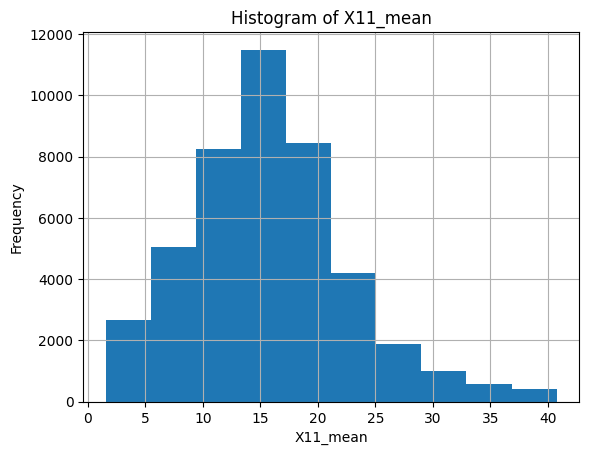

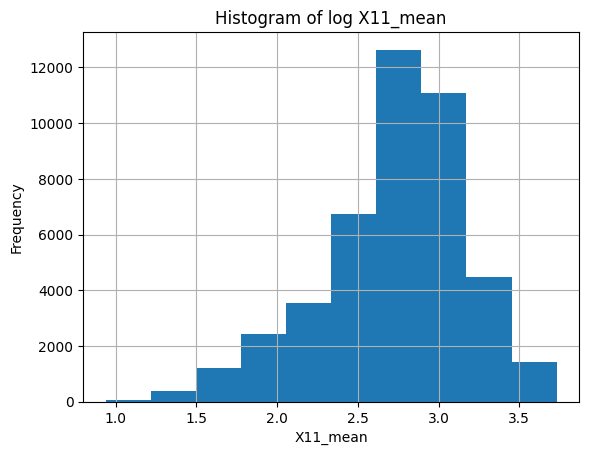

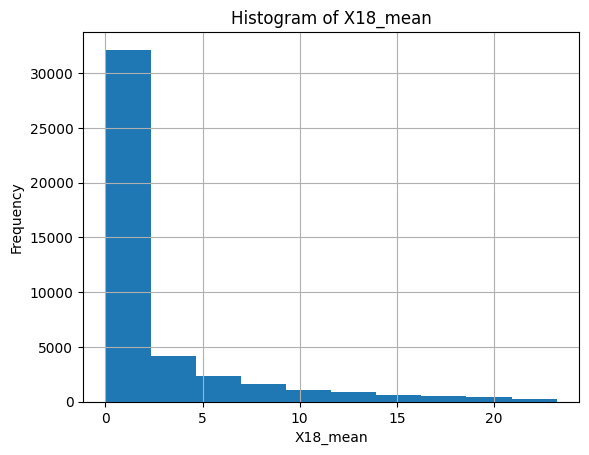

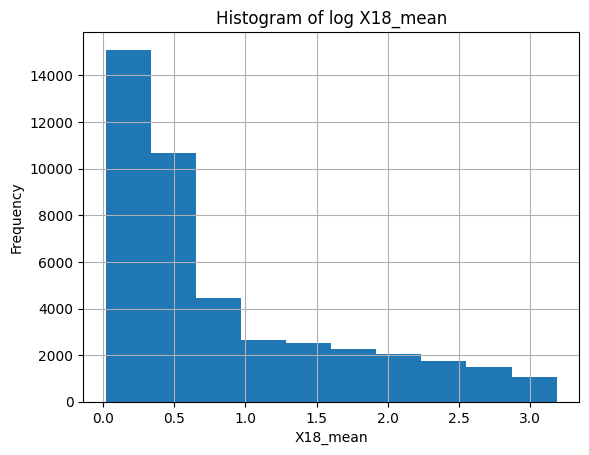

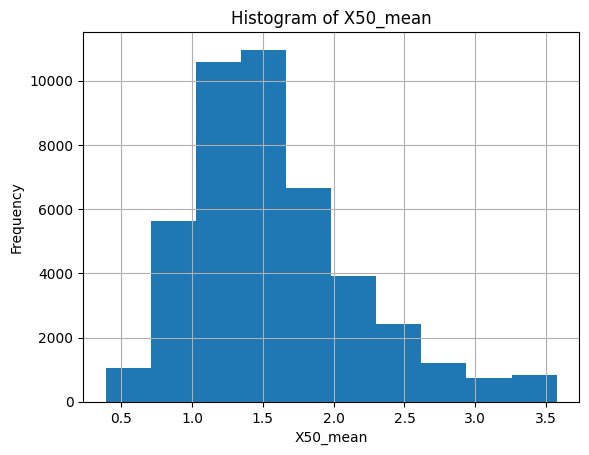

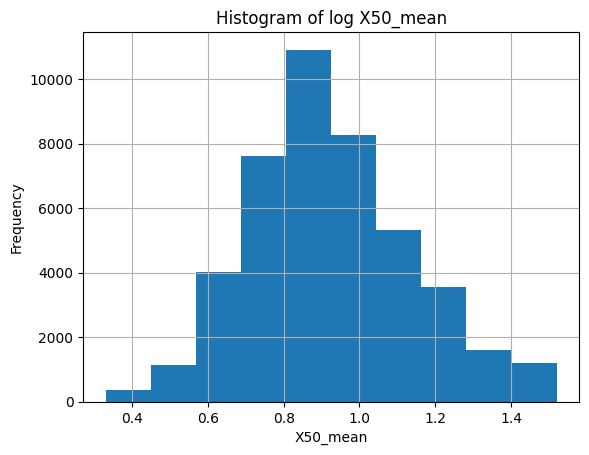

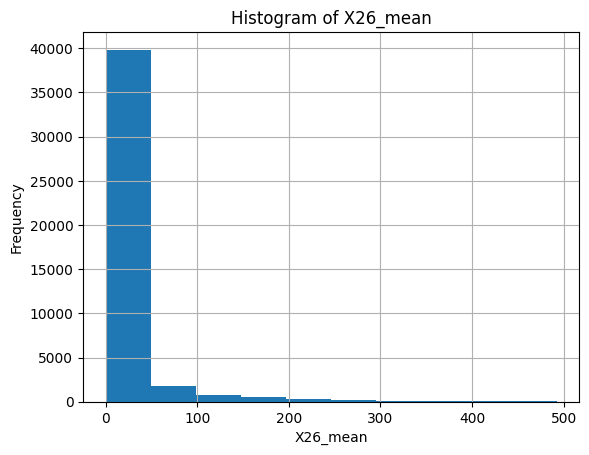

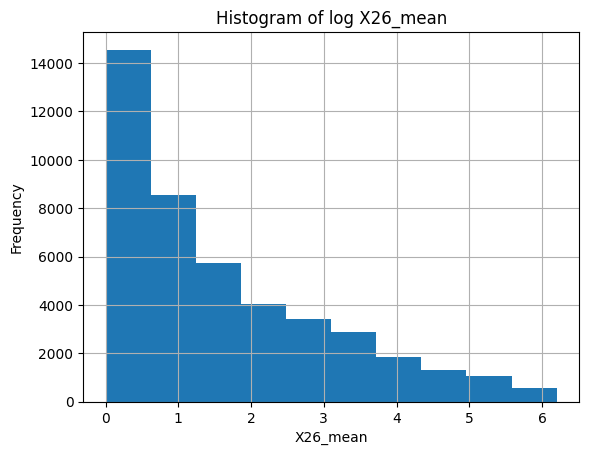

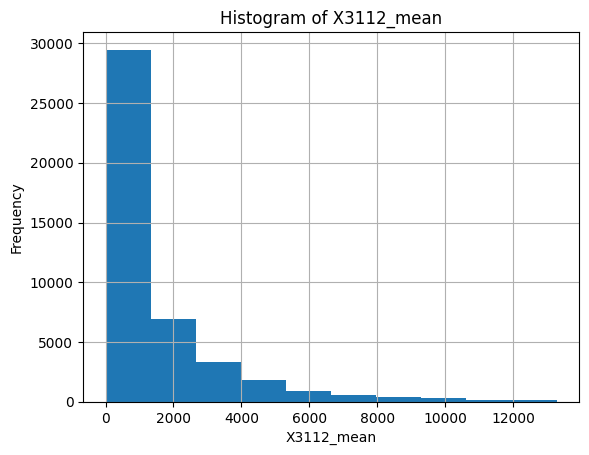

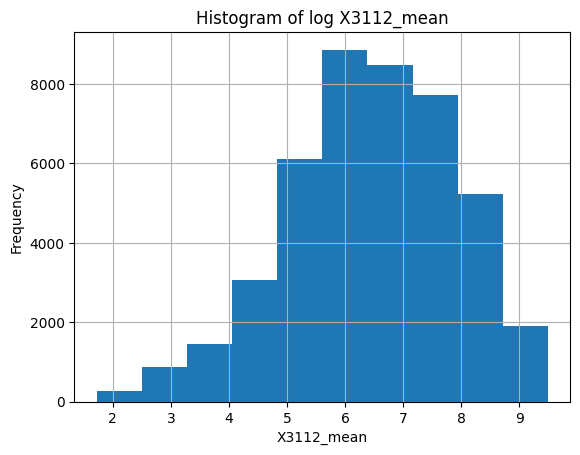

In [10]:
columns_to_log = ['X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

for column in columns_to_log:

    plt.figure()

    train_df[column].hist()

    plt.title(f'Histogram of {column}')

    plt.xlabel(column)

    plt.ylabel('Frequency')
    
    plt.figure()

    train_df[column] = np.log(train_df[column]+1)
    
    train_df[column].hist()

    plt.title(f'Histogram of log {column}')

    plt.xlabel(column)

    plt.ylabel('Frequency')



In [11]:
# Config.TARGET_MEDIANS = df_clean[Config.TARGET_COLS].median(axis=0).values


In [12]:
Config.Log_mean = train_df[Config.TARGET_COLS].mean(axis=0).values
Config.Log_std = train_df[Config.TARGET_COLS].std(axis=0).values
print(Config.Log_mean,Config.Log_std)

[0.51346869 2.72943474 0.85515135 0.92399801 1.60291551 6.45949943] [0.13733706 0.4480538  0.8054093  0.21523689 1.46656209 1.44045839]


# Normalizing data

In [13]:
normal_values = (train_df[Config.TARGET_COLS] - Config.Log_mean) / Config.Log_std

In [14]:
train_df[Config.TARGET_COLS] = normal_values

In [15]:
train_df['id'] = train_df['id'].astype(str)

In [16]:
train_df['combined']= train_df[['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']].values.tolist()

train_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X50_mean,X26_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,combined
50812,193853190,17.591135,31.000000,4.000000,36.596432,238.685974,20.151531,134,149,139,...,0.618518,0.602360,0.504633,NaN,NaN,NaN,NaN,NaN,NaN,"[-1.0022345256609868, -0.5061793015098424, -0.5216016512840521, 0.6185179817307881, 0.6023600663226889, 0.5046325873022903]"
28478,193922368,14.148741,815.822205,169.791107,92.399834,396.048767,21.251110,122,149,135,...,-0.223564,-1.051248,0.877136,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.33015403656943343, -0.4684338369964362, 0.5003535601279698, -0.2235642605315704, -1.0512477564832283, 0.877135776172964]"
26014,111677933,23.112667,536.217773,103.724442,88.554703,328.245422,22.811998,139,150,144,...,0.896330,-0.057304,0.489506,NaN,NaN,NaN,NaN,NaN,NaN,"[2.1928314157682216, 0.04646122703976981, -0.5900217279483144, 0.8963303458420607, -0.05730409129317919, 0.4895061945713752]"
29340,149721323,11.745238,1369.392822,252.607147,80.385849,289.879608,18.150000,100,122,108,...,-0.263163,0.886856,-0.039572,NaN,NaN,NaN,NaN,NaN,NaN,"[1.5024238419800449, -0.9629051457158523, 2.1012338685520895, -0.2631631656770674, 0.8868559342744124, -0.03957215446881424]"
24719,175668800,18.977282,2474.133301,161.495239,26.044340,36.119034,8.919524,87,98,93,...,-2.130922,-0.966204,1.267530,0.003161,0.320612,0.027683,0.004555,0.012420,198.633019,"[-1.4879023550706638, 0.5932095170710933, -0.3830437655087602, -2.1309222335858236, -0.9662039694203106, 1.2675296723017162]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12846,161140462,11.232589,234.785721,14.000000,22.117985,992.117981,42.767857,141,157,152,...,0.575265,-0.598636,-0.935486,0.007837,0.899775,0.020401,0.209888,0.025672,9.231840,"[-0.11500711372120605, 0.9865156774648792, -0.7257367534404436, 0.575264701727182, -0.5986357836110402, -0.9354861696060851]"
50829,195789396,15.094167,600.738098,126.233330,93.250137,462.578613,26.537144,128,156,143,...,1.303929,0.763990,-0.220749,0.003368,0.137471,0.086737,0.689401,0.086963,10.479421,"[0.9677489031303689, -2.534031142415092, 0.6595847051960756, 1.303929335400329, 0.763989961368712, -0.22074858494712774]"
43369,187791470,16.841667,1788.533325,55.333332,11.042320,328.816284,18.016666,95,116,102,...,-1.130633,-0.992652,-0.215859,0.007895,0.195212,0.003825,0.006318,0.007389,8.498377,"[-0.6432199694981655, -0.36581804309862453, -0.8081498903163197, -1.1306326742823354, -0.9926524334270889, -0.21585932211733672]"
983,196488912,20.575893,1583.142822,183.000000,44.764801,376.340210,21.164284,112,127,122,...,1.317375,0.347407,1.013829,0.009829,0.401679,0.354279,3.360264,0.062182,814.812511,"[0.5674969086749397, -0.5322683594419586, 0.27414642249744414, 1.3173747513437972, 0.34740694181853754, 1.0138294674867372]"


# Creating dataloader

In [17]:
training_data = train_df

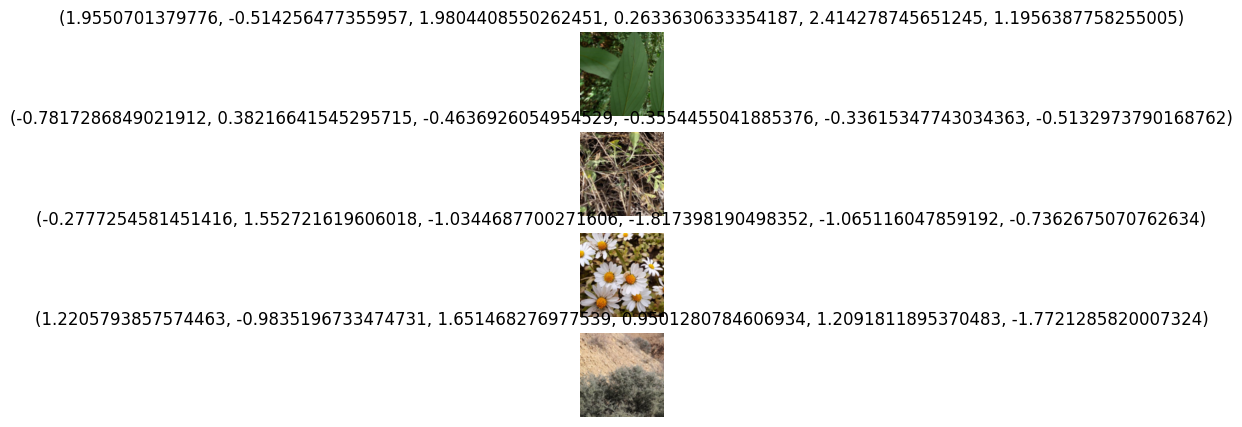

In [18]:
plant = DataBlock(blocks = (ImageBlock, RegressionBlock(n_out=6)),
                 get_x = ColReader('id', pref=f'/kaggle/input/planttraits2024/train_images/' ,suff='.jpeg'),
                 get_y = ColReader('combined'),
                 splitter = RandomSplitter(valid_pct=0.10,seed=42),
                 batch_tfms=aug_transforms(min_scale = 0.75,size=224),
                 item_tfms = Resize(224),
                 )


dls = plant.dataloaders(training_data)
dls.show_batch(nrows=4,ncols=1,figsize=(5,5))

# Traning and custom loss 

## Custom loss fuction 

In [19]:
def r2loss(y_pred,y_true ):
        var_y = torch.var(y_true, unbiased=False)
        return F.mse_loss(y_pred, y_true, reduction="mean") / var_y

In [20]:
learn = vision_learner(dls,"timm/vit_small_patch8_224.dino",  metrics=[mse,R2Score()], loss_func=r2loss)


model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [21]:
learn.fine_tune(8,0.0030199517495930195)

epoch,train_loss,valid_loss,mse,r2_score,time
0,0.842619,0.742444,0.744137,0.262160,17:27


epoch,train_loss,valid_loss,mse,r2_score,time
0,0.711641,0.670903,0.672293,0.333397,20:31
1,0.703461,0.659063,0.660505,0.345084,20:31
2,0.669549,0.646120,0.647684,0.357797,20:32
3,0.616196,0.629769,0.630501,0.374835,20:32
4,0.576902,0.609481,0.610007,0.395155,20:33
5,0.532787,0.604295,0.604946,0.400174,20:33
6,0.503979,0.606216,0.606628,0.398506,20:33
7,0.493205,0.603674,0.604263,0.400851,20:32


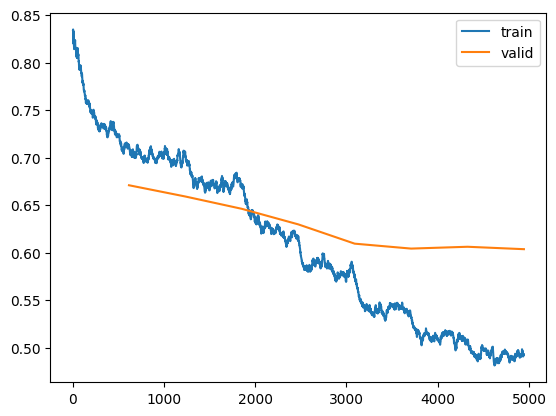

In [22]:
learn.recorder.plot_loss()

# Feature Extraction

## Data preprocessing for feature extracting

In [23]:
df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X50_mean,X26_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.849375,1.243779,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,1.353468,0.642940,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,2.343153,0.395241,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,1.155308,0.154200,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,2.246226,10.919966,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55484,190558785,19.472172,244.795914,39.127552,67.074493,472.710358,27.758673,118,140,131,...,0.233690,1.608341,1.783193,969.547831,NaN,NaN,NaN,NaN,NaN,NaN
55485,194523231,13.724150,1450.000000,162.260208,43.139324,652.716858,26.694387,125,144,135,...,1.017099,2.418300,12.713048,1630.015480,0.005474,0.128133,0.117010,3.164520,0.082212,136.503697
55486,195888987,14.741204,581.866638,109.231110,89.272148,507.273010,26.874668,118,155,136,...,2.717395,2.722599,10.206478,602.229880,0.019727,0.215040,0.156309,0.919139,0.079395,26.159626
55487,135487319,16.094763,1180.838135,80.176193,22.909716,342.184021,17.346189,109,130,117,...,4.429659,3.251739,9.372170,244.387170,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df['combined']= df[['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']].values.tolist()


## Data Lodaer for feature extraction

In [25]:
df['id'] = df['id'].astype(str)


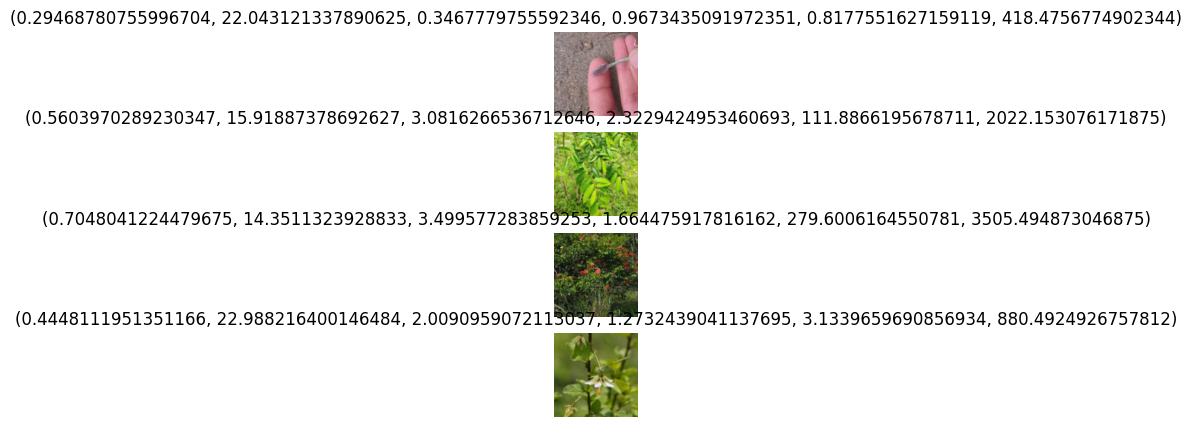

In [26]:
plant_xgb = DataBlock(blocks = (ImageBlock, RegressionBlock(n_out=6)),
                 get_x = ColReader('id', pref=f'/kaggle/input/planttraits2024/train_images/' ,suff='.jpeg'),
                 get_y = ColReader('combined'),
                 splitter = RandomSplitter(valid_pct=0.00,seed=42),
                 item_tfms = Resize(224))


dls_xgb = plant.dataloaders(df)
dls_xgb.show_batch(nrows=4,ncols=1,figsize=(5,5))

## Custom Pytorch fuction to extract activations of last hidden layer

In [27]:
from itertools import chain
def extract_features(ndf,dataloader,train = False):

    new_head = cut_model(learn.model[-1], 2)
    learn.model[-1] = new_head
    learn.model.cuda()

    def get_features(batch):
        with torch.no_grad():  
            features = learn.model(batch)
        return features

    all_features = []
    
    if train : 
        for batch in chain(dataloader.train,dataloader.valid):
            imgs = batch[0]  
            features = get_features(imgs)
            all_features.append(features)
    else:
        for batch in dataloader:
            imgs = batch[0]  
            features = get_features(imgs)
            all_features.append(features)
    
    features_tensor = torch.cat(all_features).cpu() 
    print(features_tensor.size())

    features_df = pd.DataFrame(features_tensor.numpy())
    features_df.columns = [f'feature_{i}' for i in range(features_tensor.shape[1])]
    
    # Concatenate with original DataFrame
    new_df = pd.concat([ndf.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
    
    return new_df




In [28]:
# Why is it not reducing the proper size 
df = extract_features(df,dls_xgb,train=True)

torch.Size([48853, 384])


In [29]:
df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,-2.186555,-0.682187,1.185046,2.235729,-1.225860,0.908180,-1.441875,0.303020,0.937143,0.107175
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,-1.022646,-1.411911,1.333809,1.118603,0.889113,-0.912603,-0.591839,0.581199,1.259938,0.016758
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,-0.148854,-1.334617,-0.390523,0.639324,0.658392,-0.084183,-1.403225,-0.142953,0.185994,1.346555
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,-1.158610,1.498411,1.016348,1.114785,0.134431,0.845108,1.357923,-0.519812,-1.437098,0.919971
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,-2.733183,0.684427,-0.397208,1.268910,0.713468,-0.598694,-0.869017,1.555114,0.721446,2.432144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48853,190558785,19.472172,244.795914,39.127552,67.074493,472.710358,27.758673,118,140,131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48854,194523231,13.724150,1450.000000,162.260208,43.139324,652.716858,26.694387,125,144,135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48855,195888987,14.741204,581.866638,109.231110,89.272148,507.273010,26.874668,118,155,136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48856,135487319,16.094763,1180.838135,80.176193,22.909716,342.184021,17.346189,109,130,117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = df[0:48853]

targets = df[Config.TARGET_COLS]

targets

,X4_mean,X11_mean,X18_mean,X50_mean,X26_mean,X3112_mean
0,0.401753,11.758108,0.117484,1.849375,1.243779,50.216034
1,0.480334,15.748846,0.389315,1.353468,0.642940,574.098472
2,0.796917,5.291251,8.552908,2.343153,0.395241,1130.096731
3,0.525236,9.568305,1.083629,1.155308,0.154200,1042.686546
4,0.411821,14.528877,0.657585,2.246226,10.919966,2386.467180
...,...,...,...,...,...,...
48848,0.375789,18.077815,0.922993,1.294756,3.949954,3123.383076
48849,0.473142,28.172201,0.174822,0.776344,25.070323,880.947194
48850,0.359536,11.852814,0.391445,1.648881,0.950440,406.806396
48851,0.544223,16.489486,0.331034,1.429810,0.976674,327.312662


## PreProcessing the data before putting it in XGB

In [31]:
def pre_xgb(df):
    df = df.drop(['combined'],axis=1)
    df = df.drop(["X18_sd", "X50_sd", "X3112_sd", "X11_sd", "X26_sd", "X4_sd"],axis=1)
    df = df.drop(Config.TARGET_COLS,axis=1)
    df.id = pd.to_numeric(df.id, errors='coerce').fillna(0).astype(np.int64)
    df.describe(include='all')
    return df

In [32]:
df = pre_xgb(df)

In [33]:
df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,-2.186555,-0.682187,1.185046,2.235729,-1.225860,0.908180,-1.441875,0.303020,0.937143,0.107175
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,-1.022646,-1.411911,1.333809,1.118603,0.889113,-0.912603,-0.591839,0.581199,1.259938,0.016758
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,-0.148854,-1.334617,-0.390523,0.639324,0.658392,-0.084183,-1.403225,-0.142953,0.185994,1.346555
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,-1.158610,1.498411,1.016348,1.114785,0.134431,0.845108,1.357923,-0.519812,-1.437098,0.919971
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,-2.733183,0.684427,-0.397208,1.268910,0.713468,-0.598694,-0.869017,1.555114,0.721446,2.432144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48848,143375475,25.342134,1269.821411,273.744904,104.328812,91.052284,14.505612,124,137,130,...,0.751337,-0.282163,0.952311,1.500480,0.087377,-0.759866,-1.173200,-0.851314,0.132517,-0.014033
48849,196738049,8.818889,912.524414,36.311111,16.471970,955.260071,34.401337,127,162,149,...,-1.031399,0.524593,1.212614,2.888744,0.146370,0.624131,-0.172659,0.960304,0.516066,0.573553
48850,193145264,15.907291,1166.500000,184.500000,72.396286,280.652466,20.049999,119,128,122,...,-2.654852,1.102017,1.791977,2.604050,0.533667,0.317179,-0.198215,-0.101728,0.563266,1.892146
48851,170161513,7.772279,842.102051,43.357143,20.809752,688.702271,26.403061,114,158,131,...,-1.274477,-0.838731,1.553839,-0.530362,0.612375,0.198654,-0.424734,1.456599,-1.105836,0.423603


# XGBoost

In [34]:
torch.cuda.empty_cache()

In [35]:
import xgboost as xgb
from xgboost import XGBRegressor

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=10,tree_methord="gpu_hist", gpu_id=0)
model.fit(df, targets)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, ...)

# Test set

In [36]:
def get_test_dataloader(df, path):

    def process_image(img_id): return PILImage.create(f'{path}/{img_id}.jpeg')
    
    items = df['id'].apply(process_image)
    
    dls = learn.dls.test_dl(items, with_labels=False)
    return dls

path = '/kaggle/input/planttraits2024/train_images'

# this is the local test set I have named it validation_df but it is the local test set
test_dl = get_test_dataloader(validation_df, path)

In [37]:
valid_df = extract_features(validation_df,test_dl,train=False)

torch.Size([4886, 384])


In [38]:
valid_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,feature_374,feature_375,feature_376,feature_377,feature_378,feature_379,feature_380,feature_381,feature_382,feature_383
0,195250168,10.525595,1103.035767,80.678574,30.830452,417.444489,21.903570,97,125,106,...,-0.127751,0.863665,0.299318,1.303164,-0.610786,-0.182893,0.337736,-0.306036,-0.054214,0.351913
1,96945257,27.016806,819.933350,205.199997,115.285263,316.606659,23.566666,148,151,150,...,0.958644,0.563029,1.390918,-0.841405,-2.683904,-0.324518,-0.013403,1.697181,-1.655616,-2.199849
2,189220288,0.902020,1053.744873,89.147957,36.060921,602.072632,22.368877,103,140,118,...,-2.420486,-0.315148,-1.140362,-1.604543,-0.725121,0.617789,0.210162,3.540446,0.949578,0.960223
3,186662383,13.445536,1349.785767,119.642860,32.218674,692.419128,26.171429,109,147,121,...,0.906640,-0.043383,-0.596772,-0.818726,-0.917912,-1.188832,0.851323,1.484028,0.612476,-0.646229
4,195569885,13.132162,468.380951,32.028572,23.992020,621.343262,28.078094,130,160,144,...,-1.047251,-0.146071,-0.185950,0.445603,1.169860,-1.094767,1.190677,-0.326503,-0.506931,0.129931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4881,195452077,10.345695,1133.433350,82.599998,30.269152,413.188599,21.433332,94,125,103,...,0.601375,0.535838,-1.136260,-1.346073,0.415441,0.182077,1.403885,0.582353,-0.054807,-0.729249
4882,193610339,5.935417,891.250000,68.500000,29.078445,675.560730,26.300001,95,151,116,...,-1.778163,0.317329,-0.849186,1.502096,1.589938,-0.601751,0.025928,-1.043614,0.640791,0.903827
4883,174840826,17.680166,895.556152,215.357147,112.287277,273.210724,21.089796,136,137,139,...,-1.052918,1.039538,-1.095727,-0.168013,-0.727645,0.539105,1.546334,-0.227621,1.321926,-0.549627
4884,193699720,9.656706,1323.814331,97.352379,30.923349,681.714966,25.935715,108,144,123,...,1.043945,0.111918,-0.022126,0.297955,-1.055814,0.018803,0.477186,-0.711286,-1.950627,0.541395


In [39]:
targets_list = validation_df[Config.TARGET_COLS]

In [40]:
valid_df = pre_xgb(valid_df)

In [41]:
predictions = model.predict(valid_df)

In [42]:
predictions = torch.from_numpy(predictions)
targets_list = targets_list.to_numpy()
preds_denorm = predictions.to('cuda')
targets= torch.tensor(targets_list, dtype=torch.float32).to('cuda')  

In [43]:
def r2metric(y_pred,y_true ):
        var_y = torch.var(y_true, unbiased=False)
        return 1 - F.mse_loss(y_pred, y_true, reduction="mean") / var_y

In [44]:
def msem(y_pred,y_true ):
        return  F.mse_loss(y_pred, y_true, reduction="mean")/len(targets)

In [45]:
print(r2metric(preds_denorm, targets))
print(msem(preds_denorm,targets))

tensor(0.5091, device='cuda:0')
tensor(102.5991, device='cuda:0')


In the end I was able to get 0.50 r2 score(of all the traits predicted combined), which is better than previous reserch. Combined r2 score of previous reserch is around 0.36

![paper](current.png)
